# Homework 02

In [1]:
import pandas as pd
import numpy as np
import re
import random
import os
import shutil
# !pip install tensorflow_datasets
# ! pip install tensorflow --upgrade
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import models, layers, preprocessing, optimizers, losses, metrics
tfds.disable_progress_bar()
import nltk
from nltk.corpus import stopwords
import keras.layers
from keras import backend as K

import matplotlib.pyplot as plt

tf.get_logger().setLevel('ERROR')

## Task 1

In [2]:
# Dataset can be download from the website https://strubell.github.io/teaching/11-830/assignments/files/civility_data.tar.gz
def inspect_NaN(df):
    '''To check nan value from the dataframe '''
    is_nan=df.isna()
    has_nan_row=is_nan.any(axis=1)
    print(df[has_nan_row])
dev_df=pd.read_csv("civility_data/dev.tsv",sep="\t",header=0)
mini_demodev_df=pd.read_csv("civility_data/mini_demographic_dev.tsv",sep="\t",header=0)

In [3]:
mini_demodev_df=mini_demodev_df.fillna(0)

In [4]:
dev_df.loc[dev_df.perspective_score>0.8,"label_ps"]='OFF'
dev_df.loc[dev_df.perspective_score<=0.8,"label_ps"]='NOT'

In [5]:
mini_demodev_df.loc[mini_demodev_df.perspective_score>0.8,"label_ps"]='OFF'
mini_demodev_df.loc[mini_demodev_df.perspective_score<=0.8,"label_ps"]="NOT"

In [6]:
class Matrics:
    def __init__(self,targets,gold):
        self.tp=0
        self.tn=0
        self.fp=0
        self.fn=0
        self.targetsize=len(targets)
        for i in range(len(targets)):
            if targets[i] ==1. and gold[i] ==1.: # classify offensive claim as OFF
                self.tp+=1
            elif targets[i] == 0. and gold[i] == 0.: # classify non-offensive claim as NOT
                self.tn+=1
            elif targets[i] == 0. and gold[i] ==1.: # classify offensive claim as NOT
                self.fp+=1
            elif targets[i] == 1. and gold[i]== 0.: # classify non-offensive claim as OFF
                self.fn+=1

    def f1_score(self):
        p=self.precision()
        r=self.recall()
        return 2*((p*r)/(p+r))

    def precision(self):
        tp=self.tp
        fp=self.fp
        return tp/(tp+fp)

    def recall(self):
        tp = self.tp
        fn = self.fn
        return tp/(tp+fn)

    def accuracy(self,targets,gold):
        right=0
        for x,y in zip(targets,gold):
            if x==y:
                right+=1
        return right/len(targets)

    def PFR_score(self,mini_demodev_df):
        white_misclass=len(mini_demodev_df.loc[(mini_demodev_df['demographic']=='White') & (mini_demodev_df['perspective_score']>0.8)]) # the number of label should be non-toxic classified as toxic though for White.
        hispanic_misclass=len(mini_demodev_df.loc[(mini_demodev_df['demographic']=='Hispanic') & (mini_demodev_df['perspective_score']>0.8)]) # the number of label should be non-toxic classified as toxic though for Hispanic.
        AA_misclass=len(mini_demodev_df.loc[(mini_demodev_df['demographic']=='AA') & (mini_demodev_df['perspective_score']>0.8)]) # the number of label should be non-toxic classified as toxic though for African American.
        other_misclass=len(mini_demodev_df.loc[(mini_demodev_df['demographic']=='Other') & (mini_demodev_df['perspective_score']>0.8)]) # the number of label should be non-toxic classified as toxic though for other.

        FPR_white=white_misclass/len(mini_demodev_df.loc[mini_demodev_df['demographic']=='White'])
        FPR_hispanic=hispanic_misclass/len(mini_demodev_df.loc[mini_demodev_df['demographic']=='Hispanic'])
        FPR_AA=AA_misclass/len(mini_demodev_df.loc[mini_demodev_df['demographic']=='AA'])
        FPR_other=other_misclass/len(mini_demodev_df.loc[mini_demodev_df['demographic']=='Other'])
        FPR_list=[FPR_white,FPR_hispanic,FPR_AA,FPR_other]
        print("The FPR for the group White is {0}\nThe FPR for the group Hispanic is {1}\nThe FPR for the group AA is {2}\nThe FPR for the group Other is {3}".format(FPR_white,FPR_hispanic,FPR_AA,FPR_other))
        return FPR_list

    def summary(self,targets,golds):
        print("The accuracy is {0}".format(self.accuracy(targets,golds)))
        print("The F1_score is {0}".format(self.f1_score()))

def normalize_label(labels):
    '''
    encode label to 0,1. 'OFF' to 1, 'NOT' to 0
    '''
    labels_encoded=[]
    for label in labels:
        if label=='OFF':
            labels_encoded.append(1)
        elif label=='NOT':
            labels_encoded.append(0)
    if len(labels_encoded)!=len(labels):
        raise ValueError
    else:
        return labels_encoded


### 1.1b

In [7]:
print('-'*30+'1.1.b Starting '+'-'*30)
dev_y=dev_df.label.tolist()
dev_X=dev_df.label_ps.tolist()
dev_y=normalize_label(dev_y)
dev_X=normalize_label(dev_X)
m=Matrics(dev_X,dev_y)
m.summary(dev_X,dev_y)
print('-'*30+'1.1.b Ending '+'-'*30)

------------------------------1.1.b Starting ------------------------------
The accuracy is 0.7643504531722054
The F1_score is 0.4851485148514852
------------------------------1.1.b Ending ------------------------------


### 1.1c

In [8]:
print('-'*30+'1.1.c Starting '+'-'*30)
mini_demodev_X=mini_demodev_df.label_ps.tolist()
mini_demodev_X=normalize_label(mini_demodev_X)
mini_demodev_y=np.zeros(len(mini_demodev_X)).tolist()
m=Matrics(mini_demodev_X,mini_demodev_y)
m.PFR_score(mini_demodev_df)
print('-'*30+'1.1.c Ending '+'-'*30)

------------------------------1.1.c Starting ------------------------------
The FPR for the group White is 0.07319952774498228
The FPR for the group Hispanic is 0.10149253731343283
The FPR for the group AA is 0.1897590361445783
The FPR for the group Other is 0.011764705882352941
------------------------------1.1.c Ending ------------------------------


### 1.1d Briefly explain your results

In [9]:
print('='*30+'1.2 Custom Classifier Starting '+'='*30)

==============================1.2 Custom Classifier Starting ==============================


In [10]:
random.seed(42)
tf.random.set_seed(42)

def normalize_label(labels):
    '''
    encode label to 0,1. 'OFF' to 1, 'NOT' to 0
    '''
    labels_encoded=[]
    for label in labels:
        if label=='OFF':
            labels_encoded.append((0,1))
        elif label=='NOT':
            labels_encoded.append((1,0))
    if len(labels_encoded)!=len(labels):
        raise ValueError
    else:
        return labels_encoded


def df_to_dataset(dataframe, shuffle=True, batch_size=32):
  dataframe = dataframe.copy()
  labels = dataframe.pop('label')
  labels=np.array(normalize_label(labels))
  ds = tf.data.Dataset.from_tensor_slices((dataframe.text.values,labels)) #create a dataset is to create it from a list
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size) #Combines consecutive elements of this dataset into batches
  ds = ds.prefetch(batch_size) # Creates a Dataset that prefetches (pre-processing) elements from this dataset.
  return ds



def read_data(filepath,batch_size=50):
    df = pd.read_csv(filepath,sep='\t',header=0)
    batch_size=batch_size
    df.text=df.text.apply(lambda x : preprocessing(x))

    train_ds = df_to_dataset(df, batch_size=batch_size)

    return train_ds

def preprocessing(sentence):
    # remove @User
    # result=' '.join(re.sub("(@[A-Za-z0-9]+)"," ",sentence).split())
    restr=r"(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'\".,<>?«»“”‘’]))"
    text_noURL=re.sub(restr," ", sentence)
    text_noHashTag=re.sub("#"," ", text_noURL)
    text_noHashTag=re.sub("(@[A-Za-z0-9]+)"," ",text_noHashTag)
    text_noPunc=re.sub("[^a-zA-Z#]"," ", text_noHashTag)
    words=[word for word in text_noPunc.lower().split() if word not in stopwords.words("english")]
    result=' '.join(words)

    # remove punctuation



    return result

# tmp='Yes you are but I was asking what is it @User about the movie ?🤷‍♂️👀	'
# preprocessing(tmp)
# train=read_data("civility_data/train.tsv")
# dev=read_data("civility_data/dev.tsv")


In [11]:
# for example, label in train.take(1):
#   print('text: ', example.numpy())
#   print('label: ', label.numpy())
# rep=[word for item in text for word in item.split()]
# print(len(set(rep)))
# VOCAB_SIZE = 10000
# encoder = tf.keras.layers.TextVectorization(
#     max_tokens=VOCAB_SIZE)
# encoder.adapt(train.map(lambda text, label: text))
# encoded_example = encoder(example)[:3].numpy()
# encoded_example
# len(encoder.get_vocabulary())

------------------------------Starting reading data and preprocessing------------------------------
------------------------------End preprocessing------------------------------
------------------------------Starting training model------------------------------
Epoch 1/40
265/265 [==============================] - 32s 59ms/step - loss: 0.6679 - accuracy: 0.6669 - f1_m: 0.1150 - precision_m: 0.3428 - recall_m: 0.0740 - val_loss: 0.6473 - val_accuracy: 0.6677 - val_f1_m: 0.4515 - val_precision_m: 0.6621 - val_recall_m: 0.3463
Epoch 2/40
265/265 [==============================] - 9s 34ms/step - loss: 0.6239 - accuracy: 0.6743 - f1_m: 0.4721 - precision_m: 0.7200 - recall_m: 0.3550 - val_loss: 0.6116 - val_accuracy: 0.6956 - val_f1_m: 0.5532 - val_precision_m: 0.7469 - val_recall_m: 0.4426
Epoch 3/40
265/265 [==============================] - 10s 36ms/step - loss: 0.4977 - accuracy: 0.7954 - f1_m: 0.6833 - precision_m: 0.8431 - recall_m: 0.5794 - val_loss: 0.5823 - val_accuracy: 0.7319 - v

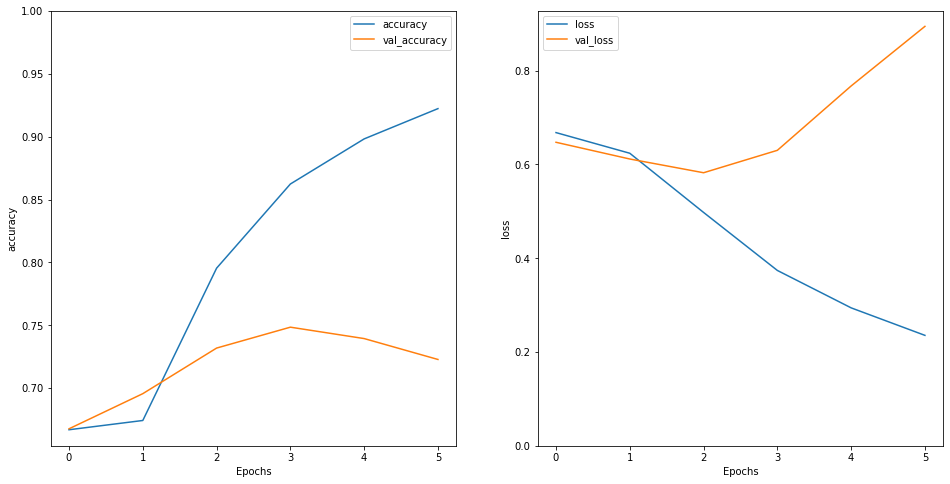

In [12]:
class RNNClassifier:
    def __init__(self,encoder,modelsavepath='model/my_model.cpdk', modelloadpath='model/my_model.cpdk'):
        self.model=self.build_model(encoder)
        self.MODELSAVEPATH=modelsavepath
        self.MODELSAVEPATH=modelloadpath

    def build_model(self,encoder):
        model = tf.keras.Sequential([
            encoder,
            tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
            tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
            tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
            tf.keras.layers.Dense(64, activation='relu'),
            tf.keras.layers.Dropout(0.5),
            tf.keras.layers.Dense(2)
        ])


        def recall_m(y_true, y_pred):
            true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
            possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
            recall = true_positives / (possible_positives + K.epsilon())
            return recall

        def precision_m(y_true, y_pred):
            true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
            predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
            precision = true_positives / (predicted_positives + K.epsilon())
            return precision

        def f1_m(y_true, y_pred):
            precision = precision_m(y_true, y_pred)
            recall = recall_m(y_true, y_pred)
            return 2*((precision*recall)/(precision+recall+K.epsilon()))


        model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                      optimizer=tf.keras.optimizers.Adam(1e-4),
                      metrics=['accuracy',f1_m,precision_m, recall_m])

        return model

    def train(self,train,dev,epochs=40):
        callback_list=[
            keras.callbacks.EarlyStopping(
                monitor='val_accuracy',
                patience=2,
                mode="max"
            ),
            keras.callbacks.ModelCheckpoint(
                filepath=self.MODELSAVEPATH,
                monitor='val_loss',
                save_weights_only=True,
                save_best_only=True,
            )
        ]
        model=self.model
        history = model.fit(train, epochs=epochs,validation_data=dev,callbacks=callback_list)
        model.save_weights(self.MODELSAVEPATH)
        self.loss_figure(history)
        self.model=model

    def load_weights(self):
        self.model=self.load_weights(self.MODELSAVEPATH)

    def loss_figure(self,history):
        plt.figure(figsize=(16, 8))
        plt.subplot(1, 2, 1)
        self.plot_graphs(history, 'accuracy')
        plt.ylim(None, 1)
        plt.subplot(1, 2, 2)
        self.plot_graphs(history, 'loss')
        plt.ylim(0, None)

    def plot_graphs(self,history, metric):
      plt.plot(history.history[metric])
      plt.plot(history.history['val_'+metric], '')
      plt.xlabel("Epochs")
      plt.ylabel(metric)
      plt.legend([metric, 'val_'+metric])




print("-"*30+"Starting reading data and preprocessing"+"-"*30)
train=read_data("civility_data/train.tsv",batch_size=40)
dev=read_data("civility_data/dev.tsv",batch_size=40)
print("-"*30+"End preprocessing"+"-"*30)

print("-"*30+"Starting training model"+"-"*30)
VOCAB_SIZE = 10000
encoder = tf.keras.layers.TextVectorization(max_tokens=VOCAB_SIZE)
encoder.adapt(train.map(lambda text, label: text))
classifier=RNNClassifier(encoder=encoder)
classifier.train(train,dev)
print("-"*30+"End training model"+"-"*30)



In [13]:
loss, acc, f1_m, precision_m, recall_m=classifier.model.evaluate(dev)
print("The accuracy is {0}, the f1-score is {1}".format(acc,f1_m))

34/34 [==============================] - 0s 9ms/step - loss: 0.8945 - accuracy: 0.7228 - f1_m: 0.7084 - precision_m: 0.7362 - recall_m: 0.6831
The accuracy is 0.7228096723556519, the f1-score is 0.7083631157875061


In [14]:
def decoder_label(vec_labels):
    results=[]
    for item in vec_labels:
        results.append(np.argmax(item))
    return results

def PFR_score_RNN(mini_demodev_df):
    white_misclass=len(mini_demodev_df.loc[(mini_demodev_df['demographic']=='White') & (mini_demodev_df['label_RNN']==1)]) # the number of label should be non-toxic classified as toxic though for White.
    hispanic_misclass=len(mini_demodev_df.loc[(mini_demodev_df['demographic']=='Hispanic') & (mini_demodev_df['label_RNN']==1)]) # the number of label should be non-toxic classified as toxic though for Hispanic.
    AA_misclass=len(mini_demodev_df.loc[(mini_demodev_df['demographic']=='AA') & (mini_demodev_df['label_RNN']==1)]) # the number of label should be non-toxic classified as toxic though for African American.
    other_misclass=len(mini_demodev_df.loc[(mini_demodev_df['demographic']=='Other') & (mini_demodev_df['label_RNN']==1)]) # the number of label should be non-toxic classified as toxic though for other.

    FPR_white=white_misclass/len(mini_demodev_df.loc[mini_demodev_df['demographic']=='White'])
    FPR_hispanic=hispanic_misclass/len(mini_demodev_df.loc[mini_demodev_df['demographic']=='Hispanic'])
    FPR_AA=AA_misclass/len(mini_demodev_df.loc[mini_demodev_df['demographic']=='AA'])
    FPR_other=other_misclass/len(mini_demodev_df.loc[mini_demodev_df['demographic']=='Other'])
    FPR_list=[FPR_white,FPR_hispanic,FPR_AA,FPR_other]
    print("The FPR for the group White is {0}\nThe FPR for the group Hispanic is {1}\nThe FPR for the group AA is {2}\nThe FPR for the group Other is {3}".format(FPR_white,FPR_hispanic,FPR_AA,FPR_other))
    return FPR_list

print("-"*30+"1.2.b Starting "+"-"*30)
mini_demodev_df=pd.read_csv('civility_data/mini_demographic_dev.tsv',sep='\t',header=0)
mini_demodev_df.text=mini_demodev_df.text.apply(lambda x : preprocessing(x))
result=classifier.model.predict(mini_demodev_df.text.tolist())
mini_demodev_df['label_RNN']=decoder_label(result)
PFR_score_RNN(mini_demodev_df)
print("-"*30+"1.2.b End "+"-"*30)

------------------------------1.2.b Starting ------------------------------
159/159 [==============================] - 6s 6ms/step
The FPR for the group White is 0.1881936245572609
The FPR for the group Hispanic is 0.1880597014925373
The FPR for the group AA is 0.3313253012048193
The FPR for the group Other is 0.1588235294117647
------------------------------1.2.b End ------------------------------
